# Applying BERT Multilingual Classifier to Predict Account Suspension 

Guidance from: https://github.com/kacossio/TeamPython/blob/master/Bert%20Multilingual%20Embedding.ipynb

## 1. Load Packages

In [1]:
########## Load Packages
import warnings
warnings.simplefilter("ignore")

import importlib
import pandas as pd
import numpy as np
import re
from io import StringIO
import itertools
import os 
import time
import datetime

from io import StringIO # python3; python2: BytesIO 
import boto3

import emoji
import random 
import math

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math

## 2. Set parameters

In [2]:
# Set Parameters 
########## Set Parameters

# Indicate how many rows to skip before columns
# Note: Python uses zero-based indexing, so skiprow=0 begins at the first row of file,
# while skiprow=1 begins at the second row.
skiprow=0

# Indicate name of column that contains text data for analysis
text_column = "text"

filepath = "data/"

import_bucket = "joe-exotic-2020"

embedding_bucket = "modeling/embeddings"

key = 'full_clean' # already created on S3
csv_buffer = StringIO()
s3_resource = boto3.resource('s3')
s3 = boto3.client('s3')

results_bucket = 'full_clean' # already created on S3

## 3. Load in Data from S3

In [3]:
def import_data(filelist):
    '''Read in data from excel files into Pandas dataframe.
    Inputs: Filelist 
    Outputs: Pandas dataframe containing imported data
    '''

    # Read in single file
    object_key = filelist[0].split('/', 1)[1]
    csv_obj = s3.get_object(Bucket=import_bucket, Key=object_key)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')
    df = pd.read_csv(StringIO(csv_string), error_bad_lines=False)
    
    return df

### Load in data from S3

In [4]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("train_updated",obj.key)]

df_train = import_data(filelist)

df_train['suspended'] = pd.to_numeric(df_train['suspended'], errors='coerce')
df_train = df_train[df_train['suspended'].notna()]

# Import Test and Measure Balance

filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("test_updated",obj.key)]

df_test = import_data(filelist)

df_test['suspended'] = pd.to_numeric(df_test['suspended'], errors='coerce')
df_test = df_test[df_test['suspended'].notna()]

# Import Validation and Measure Balance
# Import Flattened Data
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("valid_updated",obj.key)]

df_valid = import_data(filelist)

df_valid['suspended'] = pd.to_numeric(df_valid['suspended'], errors='coerce')
df_valid = df_valid[df_valid['suspended'].notna()]

### Supplementary Pre-Processing

#### Ensure that Target Variable is Numeric 

In [5]:
df_train['suspended'] = df_train['suspended'].astype(int)
df_valid['suspended'] = df_valid['suspended'].astype(int)
df_test['suspended'] = df_test['suspended'].astype(int)

#### Remove Duplicates 

In [6]:
df_train = df_train.drop_duplicates(subset=['id', 'created_at', 'text'])
df_valid = df_valid.drop_duplicates(subset=['id', 'created_at', 'text'])
df_test = df_test.drop_duplicates(subset=['id', 'created_at', 'text'])

#### Ensure binary possibly_sensitive vars

In [7]:
df_train['possibly_sensitive'][df_train['possibly_sensitive'].apply(lambda x: isinstance(x, str))] =np.nan
df_valid['possibly_sensitive'][df_valid['possibly_sensitive'].apply(lambda x: isinstance(x, str))] =np.nan
df_test['possibly_sensitive'][df_test['possibly_sensitive'].apply(lambda x: isinstance(x, str))] =np.nan

## 4. Extract Embeddings

In [8]:
#import packages 
from translate import Translator
import spacy
import langid
import keras_bert
import tensorflow as tf
import time
import datetime as dt
import pytz

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso, LogisticRegression

Using TensorFlow backend.


### Prep for Tensor 

#### Convert Dates to Unix Epoch Time

In [9]:
### Function to convert dates into float (Unix Epoch Times )
def convert_dates_float(df):
    '''
    Convert key input data variables to numeric format for tensors. Uses unix epoch time in seconds. 
    '''
    # created_at (tweet)
    df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S.%f')
    my_datetime = dt.datetime(1970,1,1) 
    good_dt = pytz.timezone('UTC').localize(my_datetime)
    df['created_at'] = (df['created_at'] - good_dt).dt.total_seconds()

    # User.created_at (account)
    df['user.created_at'] = pd.to_datetime(df['user.created_at'], format='%Y-%m-%d %H:%M:%S.%f')
    my_datetime = dt.datetime(1970,1,1) 
    good_dt = pytz.timezone('UTC').localize(my_datetime)
    df['user.created_at'] = (df['user.created_at'] - good_dt).dt.total_seconds()
    
    return df

#### Convert binary and categorical variables to one-hot encoded (not sure this is best or not)

Options 

- Integer Encoding: Where each unique label is mapped to an integer.
- One Hot Encoding: Where each label is mapped to a binary vector.
- Learned Embedding: Where a distributed representation of the categories is learned.

We use one hot encoding below. 

#### We use get_dummies below instead of one_hot_encoder as get dummies knows how to deal with missingness. 

In [10]:
### One Hote Encoding (Unix Epoch Times )
def one_hot(df_train, df_valid, df_test): 
    '''
    One hot encoding requires the full dataset in order to ensure that there end up the same amount of columns for test, validation and train.
    We therefore combine train, valid, and test, fill nas with 0 where necessary, and one hot encode categorical vars. 
    '''
    df_train['split'] = "train"
    df_valid['split'] = "valid"
    df_test['split'] = "test"
    df = pd.concat([df_train, df_test, df_valid], ignore_index=True, sort=False)
    df = convert_dates_float(df)
    # Extra layer of Processing 
    df = df[df['retweet_count'] != "False"] 
    df['quoted_status.user.followers_count'] = df['quoted_status.user.followers_count'].fillna(0) 
    df['quoted_status.user.friends_count'] = df['quoted_status.user.friends_count'].fillna(0) 
    df['retweeted_status.user.followers_count'] = df['retweeted_status.user.followers_count'].fillna(0) 
    df['retweeted_status.user.friends_count'] = df['retweeted_status.user.friends_count'].fillna(0) 
    # One-hot
    df = df.drop(["user.protected.1", "user.protected.2", "user.protected.3"], axis=1)
    df = pd.get_dummies(df, columns=["source", "lang", "possibly_sensitive", "withheld_in_countries", "place.country", 
                                         "user.geo_enabled", "user.lang", "user.verified", "user.has_extended_profile",
                                        "user.lang", "user.protected", "user.time_zone", "user.verified", "user.default_profile",
                                        "is_quote_status"])
    return df
# Tp get rid of: Text, user.protected.1, user.protected.2, user.protected.3, 
# To concat (or get rid of): user.description, user.location, user.name, user.screen_name
# to potentially take out entirely - user.id (This would explain everything)


#### Split one-hot encoded df back apart into train, valid, and test

In [11]:
df = one_hot(df_train, df_valid, df_test)
df_train_f = df[df['split'] == "train"]
df_valid_f = df[df['split'] == "valid"]
df_test_f = df[df['split'] == "test"]


#### Remove other text fields (may concatanate with tweets in future iterations)

In [12]:
df_train = df_train_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)
df_valid = df_valid_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)
df_test = df_test_f.drop(['user.description', "user.location", "user.name", "user.screen_name", "split"], axis=1)

In [13]:
df_train.head()

,id,created_at,text,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,...,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False,user.default_profile_True,is_quote_status_False,is_quote_status_True
1,1.304799e+18,1.599923e+09,containcontrast you are as worse as nazi germ...,0.0,1.0,0.0,1.278120e+18,1.593563e+09,25355.0,377.0,...,1,0,1,0,1,1,1,1,1,0
2,1.304796e+18,1.599923e+09,RT bcelyj nevernever maryann CCP CCCP CCCP,1.0,0.0,0.0,1.278120e+18,1.593563e+09,25355.0,377.0,...,1,0,1,0,1,1,1,1,1,0
3,1.304796e+18,1.599923e+09,RT maryann CCP CCP https co EAFQGqFQ,802.0,0.0,0.0,1.278120e+18,1.593563e+09,25355.0,377.0,...,1,0,1,0,1,1,1,1,1,0
4,1.304795e+18,1.599922e+09,https co oBzs zO https co Si btzc U,0.0,15.0,1.0,1.278120e+18,1.593563e+09,25355.0,377.0,...,1,0,1,0,1,1,1,1,0,1
5,1.304794e+18,1.599922e+09,https co oBzs zO Z,0.0,10.0,1.0,1.278120e+18,1.593563e+09,25355.0,377.0,...,1,0,1,0,1,1,1,1,0,1


In [14]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from numba import cuda 
import gc

In [22]:
def roundup(x, pl):
    return int(math.ceil(x / pl)) * pl

In [28]:
############# Import Data
def import_list_data(filelist):
    '''Read in data from excel files into Pandas dataframe. Concatenates multiple files if necessary. 
    Inputs: Directory path, number of rows to skip
    Outputs: Pandas dataframe containing imported data
    '''
    dataframes = []
    # Iterate through files of the directory
    for filename in filelist:
        object_key = filename.split('/', 1)[1]
        csv_obj = s3.get_object(Bucket=import_bucket, Key=object_key)
        body = csv_obj['Body']
        csv_string = body.read().decode('utf-8')
        dataframe = pd.read_csv(StringIO(csv_string))
        dataframes.append(dataframe)
    df = pd.concat(dataframes, ignore_index=True, sort=False)

    return df

In [16]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [18]:
import bert
from bert import tokenization

## 5. Base Models: Fully Connected Models (No Fine-Tuning)

In [15]:
import pandas as pd
import re
import numpy as np
from sklearn import preprocessing
import pickle
import pandas as pd
import pickle
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow import keras
import random as rn
from keras.models import Model,save_model, load_model, Sequential
from keras.layers import Flatten,AveragePooling1D,Dropout,Dense,Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import IPython
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from keras.utils import to_categorical
import pydot
import graphviz
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import kerastuner as kt
from kerastuner import HyperModel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Import Full Dataframes with Embeddings 

#### Multilingual 

In [16]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("ml_train_embeddings_df_full",obj.key)]

bert_embeddings_df_train = import_data(filelist)

In [17]:
len(bert_embeddings_df_train)

107374

In [18]:
bert_embeddings_df_train['suspended'].unique()

array([1, 0])

In [19]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("ml_valid_embeddings_df_full",obj.key)]

bert_embeddings_df_valid = import_data(filelist)

In [20]:
len(bert_embeddings_df_valid)

39537

In [21]:
bert_embeddings_df_valid['suspended'].unique()

array([0, 1])

In [22]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("ml_test_embeddings_df_full",obj.key)]

bert_embeddings_df_test = import_data(filelist)

In [23]:
len(bert_embeddings_df_test)

29139

In [24]:
bert_embeddings_df_test['suspended'].unique()

array([0, 1])

#### LabSE

In [25]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("labse_train_embeddings_df",obj.key)]

bert_embeddings_df_train_labse = import_data(filelist)

In [26]:
len(bert_embeddings_df_train_labse)

107374

In [27]:
bert_embeddings_df_train_labse['suspended'].unique()

array([1, 0])

In [28]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("labse_valid_embeddings_df",obj.key)]

bert_embeddings_df_valid_labse = import_data(filelist)

In [29]:
len(bert_embeddings_df_valid_labse)

38537

In [30]:
bert_embeddings_df_valid_labse['suspended'].unique()

array([0, 1])

In [31]:
filelist = [os.path.join(obj.bucket_name, obj.key) 
    for obj in s3_resource.Bucket(name=import_bucket).objects.all() 
    if re.findall("labse_test_embeddings_df",obj.key)]

bert_embeddings_df_test_labse = import_data(filelist)

In [32]:
len(bert_embeddings_df_test_labse)

29139

In [33]:
bert_embeddings_df_test_labse['suspended'].unique()

array([0, 1])

### Prep Data to Convert to Tensor

In [132]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,possibly_sensitive_False,possibly_sensitive_True,withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,

In [133]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train = bert_embeddings_df_train.iloc[:, bert_embeddings_df_train.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train = bert_embeddings_df_train['suspended']

#bert_embeddings_df_train.drop(['suspended'], axis=1).columns.get_loc(0)

#gets country label number
num_of_labels=labels_train.nunique()
num_of_labels

2

In [134]:
labels_train.unique()

array([1, 0])

#### Feature Selection

#### Option 1: Use Random Forest Feature Selection for Account Features 

I specify the random forest instance, indicating the number of trees. Then I use selectFromModel object from sklearn to automatically select the features.

To note, this is much faster than LASSO. 

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

Double check to ensure no missingness ahead of random forest feature selection 

In [136]:
#pd.set_option('display.max_rows', None)
acct_features_train.isna().sum()

id                              0
created_at                      0
retweet_count                1237
favorite_count               1237
quoted_status_id                0
                             ... 
user.protected_False            0
user.verified_False.1           0
user.default_profile_True       0
is_quote_status_False           0
is_quote_status_True            0
Length: 160, dtype: int64

In [137]:
acct_features_train = acct_features_train.replace([np.inf, -np.inf], np.nan)
acct_features_train['retweet_count'] = acct_features_train['retweet_count'].interpolate()
acct_features_train['favorite_count'] = acct_features_train['favorite_count'].interpolate()
acct_features_train['since_last_tweet_mins'] = acct_features_train['since_last_tweet_mins'].interpolate()
acct_features_train['since_last_tweet_mins_min'] = acct_features_train['since_last_tweet_mins_min'].interpolate()
acct_features_train['since_last_tweet_mins_max'] = acct_features_train['since_last_tweet_mins_max'].interpolate()
acct_features_train['since_last_tweet_mins_mean'] = acct_features_train['since_last_tweet_mins_mean'].interpolate()
acct_features_train['followers_per_followees'] = acct_features_train['followers_per_followees'].interpolate()
acct_features_train['user.followers_countdailychange'] = acct_features_train['user.followers_countdailychange'].interpolate()
acct_features_train['user.friends_countdailychange'] = acct_features_train['user.friends_countdailychange'].interpolate()
acct_features_train['user.friend_rate'] = acct_features_train['user.friend_rate'].interpolate()
acct_features_train['user.followers_rate'] = acct_features_train['user.followers_rate'].interpolate()
acct_features_train['user.friend_rate'] = acct_features_train['user.friend_rate'].interpolate()
acct_features_train['tweets_per_day'] = acct_features_train['tweets_per_day'].interpolate()

In [138]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

random_seeds(1234)

In [139]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(acct_features_train, labels_train)

SelectFromModel(estimator=RandomForestClassifier())

To see which features are important we can use get_support method on the fitted model. It will return an array of boolean values. True for the features whose importance is greater than the mean importance and False for the rest.

In [140]:
selected_feat= acct_features_train.columns[(sel.get_support())]
len(selected_feat)

30

In [141]:
selected_feat

Index(['id', 'created_at', 'user.id', 'user.created_at',
       'user.favourites_count', 'user.followers_count', 'user.friends_count',
       'user.statuses_count', 'user_age', 'tweets_per_day',
       'since_last_tweet_mins_min', 'since_last_tweet_mins_max',
       'since_last_tweet_mins_mean', 'avg_tweets_per_hr', 'avg_tweets_per_day',
       'followers_per_followees', 'user.urls_per_tweet',
       'no_hashtags_per_tweet', 'no_mentions_per_tweet', 'no_urls_per_tweet',
       'user.followers_countdailychange', 'user.friends_countdailychange',
       'user.friend_rate', 'user.followers_rate', 'user.has_location',
       'user.screen_name.digit_length', 'user.screen_name.length',
       'source_Twitter Web App', 'source_Twitter for Android',
       'source_Twitter for iPhone'],
      dtype='object')

<AxesSubplot:>

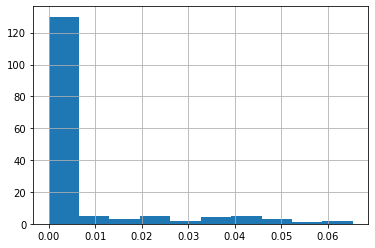

In [142]:
#pd.series(sel.estimator_,feature_importances_,.ravel()).hist()
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

Subset the account features dataset to include only important vars as determined by RF feature selection

In [143]:
acct_features_train = acct_features_train[selected_feat]
combined_features_train = pd.concat([acct_features_train, text_feature_train], axis=1)

#### Option 2: Lasso RL1 egularization (with Random Forest classification) method for feature selection 

Chose to use RF, but can come back to. 

In [72]:
scaler = StandardScaler()
scaler.fit(acct_features_train.fillna(0))

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear')) # Requires two classes to work of course. 
sel_.fit(scaler.transform(acct_features_train.fillna(0)), labels_train)

SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                             fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None,
                                             solver='liblinear', tol=0.0001,
                                             verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [73]:
selected_feat= acct_features_train.columns[(sel.get_support())]

print('total features: {}'.format((acct_features_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 160
selected features: 30
features with coefficients shrank to zero: 23


In [74]:
removed_feats = acct_features_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index(['source_BIGO LIVE', 'source_Paper.li', 'source_TeamSight Publisher',
       'source_WShare', 'source_WordPress.com', 'lang_am', 'lang_bo',
       'lang_ckb', 'lang_gu', 'lang_km', 'lang_ml', 'lang_si', 'lang_uk',
       'lang_und', 'withheld_in_countries_['TR']', 'place.country_Mongolia',
       'place.country_Republic of Korea', 'place.country_Russia',
       'user.verified_False', 'user.protected_False', 'user.verified_False.1',
       'user.default_profile_True', 'is_quote_status_False'],
      dtype='object')

Subset account features based on LASSO-selected important features 

In [ ]:
acct_features_train = sel_.transform(acct_features_train.fillna(0))
acct_features_valid = sel_.transform(acct_features_valid.fillna(0))
acct_features_test = sel_.transform(acct_features_test.fillna(0))
acct_features_train.shape, acct_features_valid.shape, acct_features_test.shape

#### Resume after feature selection

Valid

In [144]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid = bert_embeddings_df_valid.iloc[:, bert_embeddings_df_valid.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid = bert_embeddings_df_valid['suspended']

#gets country label number
num_of_labels_valid=labels_valid.nunique()
num_of_labels_valid

2

In [145]:
acct_features_valid = acct_features_valid[selected_feat]
combined_features_valid = pd.concat([acct_features_valid, text_feature_valid], axis=1)

Test

In [146]:
combined_features_test = bert_embeddings_df_test.drop(['suspended'], axis=1)
acct_features_test = bert_embeddings_df_test.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test = bert_embeddings_df_test.iloc[:, bert_embeddings_df_test.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test = bert_embeddings_df_test['suspended']

#gets country label number
num_of_labels_test=labels_test.nunique()
num_of_labels_test

2

In [147]:
acct_features_test = acct_features_test[selected_feat]
combined_features_test = pd.concat([acct_features_test, text_feature_test], axis=1)

#### Calculate class weights to address class imbalance problem. 

In [148]:
mapping = {0:0, 1:1}

def data_prep(dataset):
    y = []
    for i in range(0,len(dataset)):
        y_val = np.zeros(2)
        y_val[mapping[dataset[i]]] = 1
        y.append(y_val)
    return np.array(y)

In [149]:
labels_train_fw = data_prep(labels_train)
len(labels_train_fw)

107374

In [150]:
class_counts = [0, 0]
for el in labels_train_fw :
    class_counts[np.argmax(el)]+=1
class_weights = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

#### Label Encoding

In [151]:
#Label encoding (Have not had work yet, but may on full data)
def label_encoding(labels):
    LE = LabelEncoder()
    fit=LE.fit(labels)
    labels =fit.transform(labels)
    labels = to_categorical(labels)
    return labels, fit

In [152]:
#Test label_encoding
labels_train, fit_train=label_encoding(labels_train)
labels_valid, fit_valid=label_encoding(labels_valid)
labels_test, fit_test=label_encoding(labels_test)

#### Text Only Model 

In [153]:
#make sure numpy array
# X
train_data_tweettext = np.array(text_feature_train)
valid_data_tweettext = np.array(text_feature_valid)
test_data_tweettext = np.array(text_feature_test)

# Y
train_labels_tweettext = labels_train
valid_labels_tweettext = labels_valid
test_labels_tweettext = labels_test

In [154]:
#input shape for tweet embeddings
input_shape_tweettext=train_data_tweettext[0].shape
input_shape_tweettext

(768,)

In [155]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

#set seed
random_seeds(1234)

In [ ]:
#Function for model flow. Does not include any parameter tuning
def model_flow(model_name, num_countries, input_shape):
    inputs = keras.Input(shape=(input_shape), name="Combined_inputs")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(32, activation="relu",name="dense_2")(x)
    x = layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(0.15)(x)
    outputs = layers.Dense(num_of_labels, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [200]:
#model flow and summary
Tweettext_model = model_flow("Tweet_text",num_of_labels, input_shape_tweettext)
Tweettext_model.summary()

Model: "Tweet_text"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                49216     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 3

In [201]:
#Compile  model
Tweettext_model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [202]:
#Fitting on training and validation data
print("Fit model on Tweet Text training data")
history_tweettext = Tweettext_model.fit(train_data_tweettext, labels_train, epochs=10, batch_size=15,
                   validation_data=(valid_data_tweettext, labels_valid), class_weight = class_weights)

Fit model on Tweet Text training data
Epoch 1/10
7159/7159 [==============================] - 19s 2ms/step - loss: 1.3542 - accuracy: 0.5712 - val_loss: 0.5589 - val_accuracy: 0.7623
Epoch 2/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.2909 - accuracy: 0.6360 - val_loss: 0.6911 - val_accuracy: 0.5709
Epoch 3/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.2759 - accuracy: 0.6483 - val_loss: 0.7406 - val_accuracy: 0.4818
Epoch 4/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.2360 - accuracy: 0.6665 - val_loss: 0.6667 - val_accuracy: 0.5972
Epoch 5/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.2357 - accuracy: 0.6612 - val_loss: 0.5952 - val_accuracy: 0.7256
Epoch 6/10
7159/7159 [==============================] - 12s 2ms/step - loss: 1.2074 - accuracy: 0.6919 - val_loss: 0.6986 - val_accuracy: 0.6033
Epoch 7/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.1874 - accura

In [203]:
# Evaluate the model on the test data
print("Evaluate on Tweet Text test data")
Tweettext_model_results = Tweettext_model.evaluate(test_data_tweettext,labels_test, batch_size=10)

Evaluate on Tweet Text test data
2914/2914 [==============================] - 3s 1ms/step - loss: 0.6768 - accuracy: 0.6048


#### Save Model

In [204]:
Tweettext_model.save('Tweettext_model.h5')  # creates a HDF5 file 'my_model.h5'
client = boto3.client('s3')
s3.upload_file(Filename='Tweettext_model.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Tweettext_model.h5')



#### Make Predictions

In [111]:
#### Load back in model 
from tensorflow.keras.models import load_model

In [206]:
from tensorflow.keras.models import load_model

s3.download_file(import_bucket,
                     'modeling/model_output/Tweettext_model.h5',
                     'Tweettext_model.h5')
# returns a compiled model
# identical to the previous one
Tweettext_model = load_model('Tweettext_model.h5')

For Tweets

In [58]:
# Generate predictions (location probabilities)
def predict_test(model,test_data, test_labels, fit):
    predictions = model.predict(test_data)
    #y_true=np.argmax(test_labels, axis=0) 
    #y_pred=np.argmax(predictions, axis =0)
    #get labels of prediction
    #label_pred=fit.inverse_transform(y_pred)
    #metrics
    report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
    return report # label_pred

In [208]:
#test predict_test
metrics_report_tweettext=predict_test(Tweettext_model,test_data_tweettext,labels_test, fit_test)

# predicted_susp_tweettext
print(metrics_report_tweettext)

              precision    recall  f1-score   support

           0       0.90      0.63      0.74     26238
           1       0.10      0.38      0.16      2901

    accuracy                           0.60     29139
   macro avg       0.50      0.51      0.45     29139
weighted avg       0.82      0.60      0.68     29139



For Accounts

In [59]:
# Generate summed probabilities at the account level 
def predict_account(model, df_mod, df_bert, df_full):
    predictions = model.predict(df_mod)[:,1]
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert['user.id'], df, left_index=True, right_index=True)
    df_fm = df_full[['user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_3 = pd.merge(df_fm, df_2, left_on='user.id', right_on='user.id')
    df_4 = df_3[['user.screen_name', 'suspended','pred']].groupby('user.screen_name').agg(['sum', 'mean'])
    df_4.drop(('suspended', 'sum'), axis = 1, inplace = True)
    df_4.columns = df_4.columns = [' '.join(col).strip() for col in df_4.columns.values]
    df_4.reset_index(level=0, inplace=True)
    df_4.columns = ["user.screen_name","suspended_label", "total_pre_prob","mean_pred_prob"]
    df_4['pred_class'] = np.where(df_4['mean_pred_prob'] > 0.5, 1,0) # Double check to make sure it's .5

    return df_4

In [210]:
train_account_preds_tweettext = predict_account(Tweettext_model, train_data_tweettext, bert_embeddings_df_train, df_train_f)

In [211]:
train_account_preds_tweettext.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")

In [212]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_tweettext = classification_report(np.array(train_account_preds_tweettext['suspended_label']), np.array(train_account_preds_tweettext['pred_class']))
print(report_tr_tweettext)

              precision    recall  f1-score   support

           0       0.98      0.68      0.80      1440
           1       0.16      0.83      0.27       110

    accuracy                           0.69      1550
   macro avg       0.57      0.75      0.54      1550
weighted avg       0.92      0.69      0.77      1550



In [213]:
valid_account_preds_tweettext = predict_account(Tweettext_model, valid_data_tweettext, bert_embeddings_df_valid, df_valid_f)

In [214]:
valid_account_preds_tweettext.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")

In [215]:
#report = classification_report(np.array(test_labels), predictions)
report_v_tweettext = classification_report(np.array(valid_account_preds_tweettext['suspended_label']), np.array(valid_account_preds_tweettext['pred_class']))
print(report_v_tweettext)

              precision    recall  f1-score   support

           0       0.91      0.62      0.74       523
           1       0.05      0.24      0.08        41

    accuracy                           0.59       564
   macro avg       0.48      0.43      0.41       564
weighted avg       0.85      0.59      0.69       564



In [216]:
test_account_preds_tweettext = predict_account(Tweettext_model, test_data_tweettext, bert_embeddings_df_test, df_test_f)

In [217]:
test_account_preds_tweettext.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")

In [218]:
#report = classification_report(np.array(test_labels), predictions)
report_te_tweettext = classification_report(np.array(test_account_preds_tweettext['suspended_label']), np.array(test_account_preds_tweettext['pred_class']))
print(report_te_tweettext)

              precision    recall  f1-score   support

           0       0.92      0.63      0.75       467
           1       0.10      0.43      0.16        44

    accuracy                           0.62       511
   macro avg       0.51      0.53      0.46       511
weighted avg       0.85      0.62      0.70       511



Tweet Text Model Results

In [60]:
def accuracy_plot(title_, history_fit):
    plt.plot(history_fit.history['accuracy'])
    plt.plot(history_fit.history['val_accuracy'])
    plt.title(title_)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

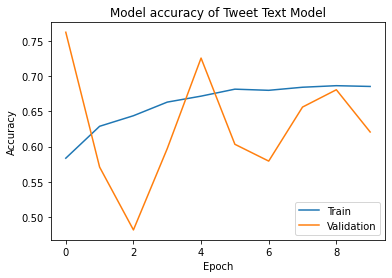

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.6767732501029968, 0.6047908067703247]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74     26238
           1       0.10      0.38      0.16      2901

    accuracy                           0.60     29139
   macro avg       0.50      0.51      0.45     29139
weighted avg       0.82      0.60      0.68     29139



In [220]:
#train vs validation accuracy plot
plot_tweettext=accuracy_plot('Model accuracy of Tweet Text Model', history_tweettext)
print(plot_tweettext)

#test accuracy
print("test loss, test accuracy:", Tweettext_model_results)
#Countries labels predicted
#print(predicted_countries_tweettext)
#Classification report
print(metrics_report_tweettext)

#### Text Only Model with LabSe

In [221]:
### Prep Data to Convert to Tensor

In [61]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train_labse.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,possibly_sensitive_False,possibly_sensitive_True,withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,

In [62]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train_labse = bert_embeddings_df_train_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train_labse = bert_embeddings_df_train_labse.iloc[:, bert_embeddings_df_train_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train_labse = bert_embeddings_df_train_labse['suspended']

In [63]:
acct_features_train_labse = acct_features_train_labse[selected_feat]
combined_features_train_labse = pd.concat([acct_features_train_labse, text_feature_train_labse], axis=1)

In [64]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid_labse = bert_embeddings_df_valid_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid_labse = bert_embeddings_df_valid_labse.iloc[:, bert_embeddings_df_valid_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid_labse = bert_embeddings_df_valid_labse['suspended']


In [65]:
acct_features_valid_labse = acct_features_valid_labse[selected_feat]
combined_features_valid_labse = pd.concat([acct_features_valid_labse, text_feature_valid_labse], axis=1)

In [66]:
acct_features_test_labse = bert_embeddings_df_test_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test_labse = bert_embeddings_df_test_labse.iloc[:, bert_embeddings_df_test_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test_labse = bert_embeddings_df_test_labse['suspended']

In [67]:
acct_features_test_labse = acct_features_test_labse[selected_feat]
combined_features_test_labse = pd.concat([acct_features_test_labse, text_feature_test_labse], axis=1)

In [68]:
labels_train_fw_labse = data_prep(labels_train_labse)
len(labels_train_fw_labse)

107374

In [69]:
class_counts = [0, 0]
for el in labels_train_fw_labse :
    class_counts[np.argmax(el)]+=1
class_weights_labse = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

In [70]:
#Test label_encoding
labels_train_labse, fit_train_labse=label_encoding(labels_train_labse)
labels_valid_labse, fit_valid_labse=label_encoding(labels_valid_labse)
labels_test_labse, fit_test_labse=label_encoding(labels_test_labse)

In [71]:
#make sure numpy array
# X
train_data_tweettext_labse = np.array(text_feature_train_labse)
valid_data_tweettext_labse = np.array(text_feature_valid_labse)
test_data_tweettext_labse = np.array(text_feature_test_labse)

# Y
train_labels_tweettext_labse = labels_train_labse
valid_labels_tweettext_labse = labels_valid_labse
test_labels_tweettext_labse = labels_test_labse

In [72]:
#input shape for tweet embeddings
input_shape_tweettext_labse=train_data_tweettext_labse[0].shape
input_shape_tweettext_labse

(768,)

In [73]:
#set seed
random_seeds(1234)

In [269]:
#model flow and summary
Tweettext_model_labse = model_flow("Tweet_text_labse",num_of_labels, input_shape_tweettext_labse)
Tweettext_model_labse.summary()

Model: "Tweet_text_labse"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                49216     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)            

In [271]:
#Compile  model
Tweettext_model_labse.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [272]:
#Fitting on training and validation data
print("Fit model on Tweet Text training data")
history_tweettext_labse = Tweettext_model_labse.fit(train_data_tweettext_labse, labels_train_labse, epochs=10, batch_size=15,
                   validation_data=(valid_data_tweettext_labse, labels_valid_labse), class_weight = class_weights_labse)

Fit model on Tweet Text training data
Epoch 1/10
7159/7159 [==============================] - 16s 2ms/step - loss: 1.3766 - accuracy: 0.4165 - val_loss: 0.6683 - val_accuracy: 0.3980
Epoch 2/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.3840 - accuracy: 0.4265 - val_loss: 0.6986 - val_accuracy: 0.3980
Epoch 3/10
7159/7159 [==============================] - 14s 2ms/step - loss: 1.3713 - accuracy: 0.4267 - val_loss: 0.6727 - val_accuracy: 0.3980
Epoch 4/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.3787 - accuracy: 0.4298 - val_loss: 0.7133 - val_accuracy: 0.3980
Epoch 5/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.3807 - accuracy: 0.4223 - val_loss: 0.6790 - val_accuracy: 0.3980
Epoch 6/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.3852 - accuracy: 0.4270 - val_loss: 0.6990 - val_accuracy: 0.3980
Epoch 7/10
7159/7159 [==============================] - 12s 2ms/step - loss: 1.3780 - accura

In [273]:
# Evaluate the model on the test data
print("Evaluate on Tweet Text test data")
Tweettext_model_results_labse = Tweettext_model_labse.evaluate(test_data_tweettext_labse,labels_test_labse, batch_size=10)

Evaluate on Tweet Text test data
2914/2914 [==============================] - 3s 934us/step - loss: 0.6674 - accuracy: 0.4372


In [274]:
Tweettext_model_labse.save('Tweettext_model_labse.h5')  # creates a HDF5 file 'my_model.h5'
client = boto3.client('s3')
s3.upload_file(Filename='Tweettext_model_labse.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Tweettext_model_labse.h5')



In [275]:
s3.download_file(import_bucket,
                     'modeling/model_output/Tweettext_model_labse.h5',
                     'Tweettext_model_labse.h5')
# returns a compiled model
# identical to the previous one
Tweettext_model_labse = load_model('Tweettext_model_labse.h5')

In [276]:
#test predict_test
metrics_report_tweettext_labse=predict_test(Tweettext_model_labse,test_data_tweettext_labse,labels_test_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_tweettext_labse)

              precision    recall  f1-score   support

           0       0.91      0.42      0.57     26238
           1       0.10      0.62      0.18      2901

    accuracy                           0.44     29139
   macro avg       0.51      0.52      0.38     29139
weighted avg       0.83      0.44      0.53     29139



Train

In [277]:
train_account_preds_tweettext_labse = predict_account(Tweettext_model_labse, train_data_tweettext_labse, bert_embeddings_df_train_labse, df_train_f)

In [278]:
train_account_preds_tweettext_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")

In [279]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_tweettext_labse = classification_report(np.array(train_account_preds_tweettext_labse['suspended_label']), np.array(train_account_preds_tweettext_labse['pred_class']))
print(report_tr_tweettext_labse)

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1440
           1       0.09      0.44      0.15       110

    accuracy                           0.65      1550
   macro avg       0.52      0.55      0.47      1550
weighted avg       0.88      0.65      0.74      1550



Valid

In [280]:
valid_account_preds_tweettext_labse = predict_account(Tweettext_model_labse, valid_data_tweettext_labse, bert_embeddings_df_valid_labse, df_valid_f)

In [281]:
valid_account_preds_tweettext_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")

In [282]:
#report = classification_report(np.array(test_labels), predictions)
report_v_tweettext_labse = classification_report(np.array(valid_account_preds_tweettext_labse['suspended_label']), np.array(valid_account_preds_tweettext_labse['pred_class']))
print(report_v_tweettext_labse)

              precision    recall  f1-score   support

           0       0.92      0.66      0.77       523
           1       0.05      0.24      0.09        41

    accuracy                           0.63       564
   macro avg       0.49      0.45      0.43       564
weighted avg       0.85      0.63      0.72       564



Test

In [283]:
test_account_preds_tweettext_labse = predict_account(Tweettext_model_labse, test_data_tweettext_labse, bert_embeddings_df_test_labse, df_test_f)

In [284]:
test_account_preds_tweettext_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_tweettext.csv', index=False, encoding = "utf_8_sig")

In [285]:
#report = classification_report(np.array(test_labels), predictions)
report_te_tweettext_labse = classification_report(np.array(test_account_preds_tweettext_labse['suspended_label']), np.array(test_account_preds_tweettext_labse['pred_class']))
print(report_te_tweettext_labse)

              precision    recall  f1-score   support

           0       0.93      0.66      0.77       467
           1       0.11      0.45      0.18        44

    accuracy                           0.65       511
   macro avg       0.52      0.56      0.48       511
weighted avg       0.86      0.65      0.72       511



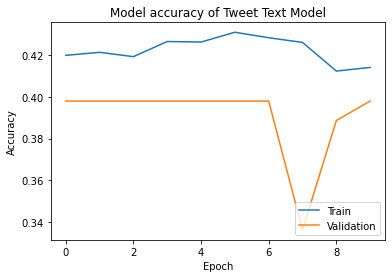

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.6673619747161865, 0.437214732170105]
              precision    recall  f1-score   support

           0       0.91      0.42      0.57     26238
           1       0.10      0.62      0.18      2901

    accuracy                           0.44     29139
   macro avg       0.51      0.52      0.38     29139
weighted avg       0.83      0.44      0.53     29139



In [286]:
#train vs validation accuracy plot
plot_tweettext=accuracy_plot('Model accuracy of Tweet Text Model', history_tweettext_labse)
print(plot_tweettext)

#test accuracy
print("test loss, test accuracy:", Tweettext_model_results_labse)
#Countries labels predicted
#print(predicted_countries_tweettext)
#Classification report
print(metrics_report_tweettext_labse)

#### Account only model  

In [156]:
#make sure numpy array
train_data_acc = np.array(acct_features_train).astype(np.float32)
valid_data_acc = np.array(acct_features_valid).astype(np.float32)
test_data_acc = np.array(acct_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [157]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(30,)

In [321]:
#Function for model flow. Does not include any parameter tuning
def model_flow(model_name, num_countries, input_shape):
    inputs = keras.Input(shape=(input_shape), name="Combined_inputs")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(32, activation="relu",name="dense_2")(x)
    x = layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(0.15)(x)
    outputs = layers.Dense(num_of_labels, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [322]:
#model flow and summary
Acc_model = model_flow("Account_Info",num_of_labels, input_shape_acc)
Acc_model.summary()

Model: "Account_Info"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 30)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1984      
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                

In [323]:
#Compile  model
Acc_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [324]:
#Fitting on training and validation data
print("Fit model on Account Information features training data")
history_acc = Acc_model.fit(train_data_acc, train_labels, epochs=10, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight=class_weights)

Fit model on Account Information features training data
Epoch 1/10
7159/7159 [==============================] - 14s 2ms/step - loss: 1.3078 - accuracy: 0.5324 - val_loss: nan - val_accuracy: 0.12290s - loss: 1.3077 - accuracy: 0.53
Epoch 2/10
7159/7159 [==============================] - 13s 2ms/step - loss: 1.2927 - accuracy: 0.5574 - val_loss: nan - val_accuracy: 0.1229
Epoch 3/10
7159/7159 [==============================] - 13s 2ms/step - loss: 1.3037 - accuracy: 0.5310 - val_loss: nan - val_accuracy: 0.1745
Epoch 4/10
7159/7159 [==============================] - 14s 2ms/step - loss: 1.2871 - accuracy: 0.5359 - val_loss: nan - val_accuracy: 0.1318
Epoch 5/10
7159/7159 [==============================] - 14s 2ms/step - loss: 1.3007 - accuracy: 0.5138 - val_loss: nan - val_accuracy: 0.1271
Epoch 6/10
7159/7159 [==============================] - 14s 2ms/step - loss: 1.2833 - accuracy: 0.5594 - val_loss: nan - val_accuracy: 0.1946
Epoch 7/10
7159/7159 [==============================] - 15

In [325]:
# Evaluate the model on the test data
print("Evaluate on Account Information features test data")
Acc_model_results = Acc_model.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate on Account Information features test data
2914/2914 [==============================] - 3s 972us/step - loss: nan - accuracy: 0.9004


#### Save Model 

In [326]:
Acc_model.save('Acc_model.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='Acc_model.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Acc_model.h5')



#### Load back in model 

In [327]:
s3.download_file(import_bucket,
                     'modeling/model_output/Acc_model.h5',
                     'Acc_model.h5')
# returns a compiled model
# identical to the previous one
Acc_model = load_model('Acc_model.h5')

#### Make Predictions

For Tweets

In [328]:
#test predict_test
metrics_report_acc=predict_test(Acc_model,test_data_acc,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_acc)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95     26238
           1       0.00      0.00      0.00      2901

    accuracy                           0.90     29139
   macro avg       0.45      0.50      0.47     29139
weighted avg       0.81      0.90      0.85     29139



For Accounts

In [330]:
train_account_preds_acc = predict_account(Acc_model, train_data_acc, bert_embeddings_df_train, df_train_f)

In [331]:
train_account_preds_acc.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [332]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_acc = classification_report(np.array(train_account_preds_acc['suspended_label']), np.array(train_account_preds_acc['pred_class']))
print(report_tr_acc)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1440
           1       0.00      0.00      0.00       110

    accuracy                           0.93      1550
   macro avg       0.46      0.50      0.48      1550
weighted avg       0.86      0.93      0.89      1550



In [357]:
valid_account_preds_acc = predict_account(Acc_model, valid_data_acc, bert_embeddings_df_valid, df_valid_f)

In [334]:
valid_account_preds_acc.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [335]:
#report = classification_report(np.array(test_labels), predictions)
report_v_acc = classification_report(np.array(valid_account_preds_acc['suspended_label']), np.array(valid_account_preds_acc['pred_class']))
print(report_v_acc)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       523
           1       0.00      0.00      0.00        41

    accuracy                           0.93       564
   macro avg       0.46      0.50      0.48       564
weighted avg       0.86      0.93      0.89       564



In [336]:
test_account_preds_acc = predict_account(Acc_model, test_data_acc, bert_embeddings_df_test, df_test_f)

In [337]:
test_account_preds_acc.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [338]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc = classification_report(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))
print(report_te_acc)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96       467
           1       0.00      0.00      0.00        44

    accuracy                           0.91       511
   macro avg       0.46      0.50      0.48       511
weighted avg       0.84      0.91      0.87       511



Account Information Model Results

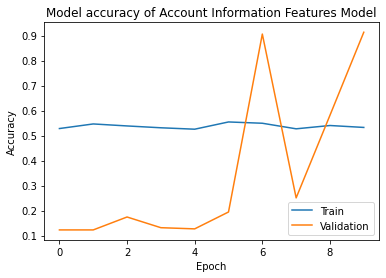

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [nan, 0.9004427194595337]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     26238
           1       0.00      0.00      0.00      2901

    accuracy                           0.90     29139
   macro avg       0.45      0.50      0.47     29139
weighted avg       0.81      0.90      0.85     29139



In [339]:
#train vs validation accuracy plot
plot_acc=accuracy_plot('Model accuracy of Account Information Features Model', history_acc)
print(plot_acc)

#train vs validation accuracy plot
print(plot_acc)
#test accuracy
print("test loss, test accuracy:", Acc_model_results)
#Countries labels predicted
#print(predicted_countries_acc)
#Classification report
print(metrics_report_acc)

#### Combined Model

Multilingual

In [158]:
#make sure numpy array
train_data = np.array(combined_features_train).astype(np.float32)
valid_data = np.array(combined_features_valid).astype(np.float32)
test_data = np.array(combined_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [163]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(798,)

In [164]:
train_data[0].shape

(798,)

In [161]:
#set seed
random_seeds(1234)

In [359]:
#test model_flow
Combined_model = model_flow("Combined",11, input_shape_combined)

In [360]:
#model summary
Combined_model.summary()


Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 798)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                51136     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 34 

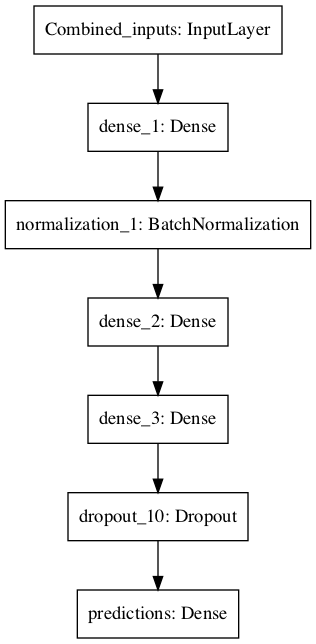

In [361]:
#model diagram
tf.keras.utils.plot_model(Combined_model)

In [362]:
#Compile  model
Combined_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [363]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined = Combined_model.fit(train_data, train_labels, epochs=10, batch_size=15,
                                      validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data
Epoch 1/10
7159/7159 [==============================] - 16s 2ms/step - loss: 1.3084 - accuracy: 0.5314 - val_loss: nan - val_accuracy: 0.1303
Epoch 2/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.2899 - accuracy: 0.5580 - val_loss: nan - val_accuracy: 0.9130
Epoch 3/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.3036 - accuracy: 0.5379 - val_loss: nan - val_accuracy: 0.1229
Epoch 4/10
7159/7159 [==============================] - 13s 2ms/step - loss: 1.2857 - accuracy: 0.5501 - val_loss: nan - val_accuracy: 0.1229
Epoch 5/10
7159/7159 [==============================] - 12s 2ms/step - loss: 1.3021 - accuracy: 0.5189 - val_loss: nan - val_accuracy: 0.1229
Epoch 6/10
7159/7159 [==============================] - 11s 2ms/step - loss: 1.2816 - accuracy: 0.5624 - val_loss: nan - val_accuracy: 0.2643
Epoch 7/10
7159/7159 [==============================] - 12s 2ms/step - loss: 1.2801 - accuracy: 0.5774 - val_loss: nan - 

In [365]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb = Combined_model.evaluate(test_data, test_labels, batch_size=10)

Evaluate on test data
2914/2914 [==============================] - 2s 846us/step - loss: nan - accuracy: 0.8985


#### Save Model 

In [366]:
Combined_model.save('Combined_model.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='Combined_model.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Combined_model.h5')



#### Load Model 

In [367]:
s3.download_file(import_bucket,
                     'modeling/model_output/Combined_model.h5',
                     'Combined_model.h5')
# returns a compiled model
# identical to the previous one
Combined_model = load_model('Combined_model.h5')

#### Predictions

Tweets

In [368]:
#test predict_test
metrics_report_comb=predict_test(Combined_model,test_data,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_comb)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     26238
           1       0.11      0.00      0.01      2901

    accuracy                           0.90     29139
   macro avg       0.51      0.50      0.48     29139
weighted avg       0.82      0.90      0.85     29139



Accounts

In [370]:
train_account_preds_comb = predict_account(Combined_model, train_data, bert_embeddings_df_train, df_train_f)

In [371]:
train_account_preds_comb.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_comb.csv', index=False, encoding = "utf_8_sig")

In [372]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_comb = classification_report(np.array(train_account_preds_comb['suspended_label']), np.array(train_account_preds_comb['pred_class']))
print(report_tr_comb)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1440
           1       0.14      0.04      0.06       110

    accuracy                           0.92      1550
   macro avg       0.53      0.51      0.51      1550
weighted avg       0.87      0.92      0.89      1550



In [373]:
valid_account_preds_comb = predict_account(Combined_model, valid_data, bert_embeddings_df_valid, df_valid_f)

In [374]:
valid_account_preds_comb.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_comb.csv', index=False, encoding = "utf_8_sig")


In [375]:
#report = classification_report(np.array(test_labels), predictions)
report_v_comb = classification_report(np.array(valid_account_preds_comb['suspended_label']), np.array(valid_account_preds_comb['pred_class']))
print(report_v_comb)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       523
           1       0.00      0.00      0.00        41

    accuracy                           0.92       564
   macro avg       0.46      0.50      0.48       564
weighted avg       0.86      0.92      0.89       564



In [376]:
test_account_preds_comb = predict_account(Combined_model, test_data, bert_embeddings_df_test, df_test_f)

In [377]:
test_account_preds_comb.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_comb.csv', index=False, encoding = "utf_8_sig")

In [378]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))
print(report_te_comb)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96       467
           1       0.00      0.00      0.00        44

    accuracy                           0.91       511
   macro avg       0.46      0.50      0.48       511
weighted avg       0.84      0.91      0.87       511



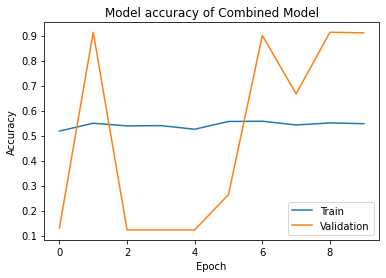

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [nan, 0.8984865546226501]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     26238
           1       0.11      0.00      0.01      2901

    accuracy                           0.90     29139
   macro avg       0.51      0.50      0.48     29139
weighted avg       0.82      0.90      0.85     29139



In [379]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined)
print(plot_combined)

#train vs validation accuracy plot
print(plot_combined)
#test accuracy
print("test loss, test accuracy:", model_results_comb)
#Countries labels predicted
#print(predicted_countries)
#Classification report
print(metrics_report_comb)

#### Labse

In [80]:
#make sure numpy array
train_data_labse = np.array(combined_features_train_labse).astype(np.float32)
valid_data_labse = np.array(combined_features_valid_labse).astype(np.float32)
test_data_labse = np.array(combined_features_test_labse).astype(np.float32)

train_labels_labse = labels_train_labse
valid_labels_labse = labels_valid_labse
test_labels_labse = labels_test_labse

In [81]:
#gets shape of the data for the model
input_shape_combined_labse=valid_data_labse[0].shape
input_shape_combined_labse

(798,)

In [82]:
#set seed
random_seeds(1234)

In [382]:
#test model_flow
Combined_model_labse = model_flow("Combined",11, input_shape_combined_labse)

In [383]:
#model summary
Combined_model_labse.summary()

Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 798)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                51136     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 34 

In [384]:
#Compile  model
Combined_model_labse.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [385]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined_labse = Combined_model_labse.fit(train_data_labse, train_labels_labse, epochs=10, batch_size=15,
                                      validation_data=(valid_data_labse, valid_labels_labse), class_weight = class_weights_labse)

Fit model on training data
Epoch 1/10
7159/7159 [==============================] - 14s 2ms/step - loss: nan - accuracy: 0.8969 - val_loss: nan - val_accuracy: 0.9118
Epoch 2/10
7159/7159 [==============================] - 14s 2ms/step - loss: nan - accuracy: 0.8942 - val_loss: nan - val_accuracy: 0.9118
Epoch 3/10
7159/7159 [==============================] - 16s 2ms/step - loss: nan - accuracy: 0.8963 - val_loss: nan - val_accuracy: 0.9118
Epoch 4/10
7159/7159 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.8947 - val_loss: nan - val_accuracy: 0.9118
Epoch 5/10
7159/7159 [==============================] - 14s 2ms/step - loss: nan - accuracy: 0.8944 - val_loss: nan - val_accuracy: 0.9118
Epoch 6/10
7159/7159 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.8941 - val_loss: nan - val_accuracy: 0.9118
Epoch 7/10
7159/7159 [==============================] - 17s 2ms/step - loss: nan - accuracy: 0.8950 - val_loss: nan - val_accuracy: 0.9118


In [386]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb_labse = Combined_model_labse.evaluate(test_data_labse, test_labels_labse, batch_size=10)

Evaluate on test data
2914/2914 [==============================] - 3s 896us/step - loss: nan - accuracy: 0.9004


In [387]:
Combined_model_labse.save('Combined_model_labse.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='Combined_model_labse.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Combined_model_labse.h5')



In [388]:
s3.download_file(import_bucket,
                     'modeling/model_output/Combined_model_labse.h5',
                     'Combined_model_labse.h5')
# returns a compiled model
# identical to the previous one
Combined_model_labse = load_model('Combined_model_labse.h5')

In [389]:
#test predict_test
metrics_report_comb_labse=predict_test(Combined_model_labse,test_data_labse,test_labels_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_comb_labse)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     26238
           1       0.00      0.00      0.00      2901

    accuracy                           0.90     29139
   macro avg       0.45      0.50      0.47     29139
weighted avg       0.81      0.90      0.85     29139



Accounts

Train

In [391]:
train_account_preds_comb_labse = predict_account(Combined_model_labse, train_data_labse, bert_embeddings_df_train_labse, df_train_f)

In [392]:
train_account_preds_comb_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")

In [393]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_comb_labse = classification_report(np.array(train_account_preds_comb_labse['suspended_label']), np.array(train_account_preds_comb_labse['pred_class']))
print(report_tr_comb_labse)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1440
           1       0.00      0.00      0.00       110

    accuracy                           0.93      1550
   macro avg       0.46      0.50      0.48      1550
weighted avg       0.86      0.93      0.89      1550



Valid

In [394]:
valid_account_preds_comb_labse = predict_account(Combined_model_labse, valid_data_labse, bert_embeddings_df_valid_labse, df_valid_f)

In [395]:
valid_account_preds_comb_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")


In [396]:
#report = classification_report(np.array(test_labels), predictions)
report_v_comb_labse_labse = classification_report(np.array(valid_account_preds_comb_labse['suspended_label']), np.array(valid_account_preds_comb_labse['pred_class']))
print(report_v_comb)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       523
           1       0.00      0.00      0.00        41

    accuracy                           0.92       564
   macro avg       0.46      0.50      0.48       564
weighted avg       0.86      0.92      0.89       564



Test

In [397]:
test_account_preds_comb_labse = predict_account(Combined_model_labse, test_data_labse, bert_embeddings_df_test_labse, df_test_f)

In [398]:
test_account_preds_comb_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")

In [399]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb_labse = classification_report(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))
print(report_te_comb_labse)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96       467
           1       0.00      0.00      0.00        44

    accuracy                           0.91       511
   macro avg       0.46      0.50      0.48       511
weighted avg       0.84      0.91      0.87       511



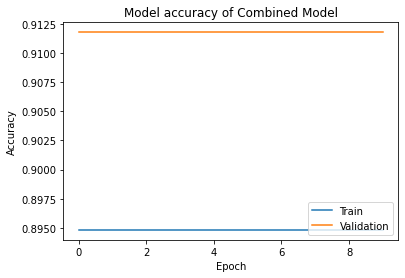

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [nan, 0.9004427194595337]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     26238
           1       0.00      0.00      0.00      2901

    accuracy                           0.90     29139
   macro avg       0.45      0.50      0.47     29139
weighted avg       0.81      0.90      0.85     29139



In [400]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined_labse)
print(plot_combined)

#train vs validation accuracy plot
print(plot_combined)
#test accuracy
print("test loss, test accuracy:", model_results_comb_labse)
#Countries labels predicted
#print(predicted_countries)
#Classification report
print(metrics_report_comb_labse)

### 3. Fine Tuning Models

#### Text Only Model 

Multilingual BERT

In [83]:
input_shape_tweettext=train_data_tweettext[0].shape
input_shape_tweettext


(768,)

In [84]:
def tuner_builder(hp):
    inputs = keras.Input(input_shape_tweettext, name="Tuned_Tweet_Text_Inputs")
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Tweet_Text_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])
    return model

In [123]:
#tuner settings 
TweetText_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3, # 
    directory = 'Trial_run_tweettext', # Reduction factor for the number of epochs and number of models for each bracket.
    project_name = 'Parameters_trials_tweettext_2')

In [89]:
#Callbacks
callback1=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

In [90]:
#clears training output
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

Thsis might take a while - I need top doublecheck how many parameters it is going through. I'm gueesing 50. 

In [126]:
#run through tuner
TweetText_tuner.search(train_data_tweettext, train_labels_tweettext,validation_data=(valid_data_tweettext, valid_labels_tweettext),
             callbacks=[callback1,ClearTrainingOutput()])

# INFO:tensorflow:Oracle triggered exit- Is that normal?

Trial 90 Complete [00h 00m 54s]
val_accuracy: 0.9127399921417236

Best val_accuracy So Far: 0.9130434989929199
Total elapsed time: 00h 42m 18s
INFO:tensorflow:Oracle triggered exit


In [127]:
#gets best parameters
best_hyper_TweetText = TweetText_tuner.get_best_hyperparameters(1)[0]
best_hyper_TweetText

In [128]:
print('Best Parameters for 1st Dense layer is', best_hyper_TweetText.get('units'))

Best Parameters for 1st Dense layer is 150


In [129]:
print('Best Parameters for 2nd Dense layer is', best_hyper_TweetText.get('units1'))

Best Parameters for 2nd Dense layer is 200


In [130]:
print('Best Parameters for 3rd Dense layer is', best_hyper_TweetText.get('units2'))

Best Parameters for 3rd Dense layer is 80


In [131]:
print('Best Parameters for Dropout layer is', best_hyper_TweetText.get('dropout'))

Best Parameters for Dropout layer is 0.30000000000000004


In [132]:
print('Best learning rate for the ADAM is', best_hyper_TweetText.get('learning_rate'))

Best learning rate for the ADAM is 0.0012918827423762096


In [133]:
#applies to tuning to model
TweetText_model_tuned= TweetText_tuner.hypermodel.build(best_hyper_TweetText)

In [134]:
#Fitting on training and validation data
print("Fit model on Tuned Tweet Text training data")
history_tweettext_tuned = TweetText_model_tuned.fit(train_data_tweettext, train_labels_tweettext, epochs=10, batch_size=15,
                   validation_data=(valid_data_tweettext, valid_labels_tweettext), class_weight = class_weights)

Fit model on Tuned Tweet Text training data
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
7159/7159 [==============================] - 19s 3ms/step - loss: 1.3931 - accuracy: 0.5687 - val_loss: 0.6551 - val_accuracy: 0.6597
Epoch 2/10
7159/7159 [==============================] - 18s 2ms/step - loss: 1.3043 - accuracy: 0.6606 - val_loss: 0.7608 - val_accuracy: 0.5476
Epoch 3/10
7159/7159 [==============================] - 20s 3ms/step - loss: 1.2846 - accuracy: 0.6654 - val_loss: 0.7800 - val_accuracy: 0.4541
Epoch 4/10
7159/7159 [==============================] - 18s 2ms/step - loss: 1.2503 - accuracy: 0.6839 - val_loss: 0.6998 - val_accuracy: 0.5468
Epoch 5/10
7159/7159 [==============================] - 17s 2ms/step - loss: 1.2509 - accuracy: 0.6743 - val_loss: 0.6350 - val_accuracy: 0.6692
Epoch 6/10
7159/7159 [==============================] - 16s 2ms/step - loss: 1.2198 - accurac

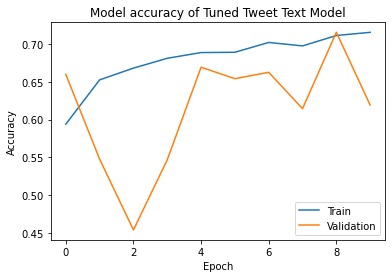

In [137]:
plot_tweettext_tuned=accuracy_plot('Model accuracy of Tuned Tweet Text Model', history_tweettext_tuned)

In [138]:
# Evaluate the model on the test data
print("Evaluate on Tuned Tweet Text test data")
Tweettext_model_tuned_results = TweetText_model_tuned.evaluate(test_data_tweettext,test_labels_tweettext, batch_size=10)

Evaluate on Tuned Tweet Text test data
2914/2914 [==============================] - 3s 1ms/step - loss: 0.6992 - accuracy: 0.6275


#### Save Model 

In [140]:
TweetText_model_tuned.save('TweetText_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='TweetText_model_tuned.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/TweetText_model_tuned.h5')

#### Load Model 

In [141]:
s3.download_file(import_bucket,
                     'modeling/model_output/TweetText_model_tuned.h5',
                     'TweetText_model_tuned.h5')
# returns a compiled model
# identical to the previous one
TweetText_model_tuned = load_model('TweetText_model_tuned.h5')



Predict

In [145]:
#test predict_test
metrics_report_tweettext_tuned=predict_test(TweetText_model_tuned,test_data_tweettext,test_labels_tweettext, fit_test)

# predicted_susp_tweettext
print(metrics_report_tweettext_tuned)

              precision    recall  f1-score   support

           0       0.91      0.65      0.76     26238
           1       0.11      0.39      0.17      2901

    accuracy                           0.63     29139
   macro avg       0.51      0.52      0.47     29139
weighted avg       0.83      0.63      0.70     29139



In [162]:
train_account_preds_tweettext_tuned = predict_account(TweetText_model_tuned, train_data_tweettext, bert_embeddings_df_train, df_train_f)
train_account_preds_tweettext_tuned

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
0,03BMsU2SEkt8d42,0,0.909805,0.454903,0
1,06ESWEE9eDlnyuD,1,90.654739,0.686778,1
2,0TnE5IV0T2ELXU1,0,10.873597,0.572295,1
3,10261026chch,1,4.992465,0.499247,0
4,1GEsShFS3GJoxoh,0,1.865694,0.621898,1
...,...,...,...,...,...
1545,zoezhan94328375,0,12.710810,0.385176,0
1546,zsN4FULPvhcM1IZ,0,2.431527,0.607882,1
1547,zubaira60720536,0,0.671181,0.335591,0
1548,zurLgxI4tqnHSVF,0,124.237175,0.575172,1


In [163]:
train_account_preds_tweettext_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_tweettext_tuned.csv', index=False, encoding = "utf_8_sig")

In [164]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_tweettext_tuned = classification_report(np.array(train_account_preds_tweettext_tuned['suspended_label']), np.array(train_account_preds_tweettext_tuned['pred_class']))
print(report_tr_tweettext_tuned)

              precision    recall  f1-score   support

           0       0.98      0.68      0.80      1440
           1       0.16      0.81      0.27       110

    accuracy                           0.69      1550
   macro avg       0.57      0.74      0.54      1550
weighted avg       0.92      0.69      0.77      1550



In [172]:
valid_account_preds_tweettext_tuned = predict_account(TweetText_model_tuned, valid_data_tweettext, bert_embeddings_df_valid, df_valid_f)

In [166]:
valid_account_preds_tweettext_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_tweettext_tuned.csv', index=False, encoding = "utf_8_sig")

In [167]:
#report = classification_report(np.array(test_labels), predictions)
report_v_tweettext_tuned = classification_report(np.array(valid_account_preds_tweettext_tuned['suspended_label']), np.array(valid_account_preds_tweettext_tuned['pred_class']))
print(report_v_tweettext_tuned)

              precision    recall  f1-score   support

           0       0.91      0.66      0.77       523
           1       0.05      0.22      0.08        41

    accuracy                           0.63       564
   macro avg       0.48      0.44      0.42       564
weighted avg       0.85      0.63      0.72       564



In [173]:
test_account_preds_tweettext_tuned = predict_account(TweetText_model_tuned, test_data_tweettext, bert_embeddings_df_test, df_test_f)

In [169]:
test_account_preds_tweettext_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_tweettext_tuned.csv', index=False, encoding = "utf_8_sig")

In [170]:
#report = classification_report(np.array(test_labels), predictions)
report_te_tweettext_tuned = classification_report(np.array(test_account_preds_tweettext_tuned['suspended_label']), np.array(test_account_preds_tweettext_tuned['pred_class']))
print(report_te_tweettext_tuned)

              precision    recall  f1-score   support

           0       0.92      0.65      0.76       467
           1       0.10      0.43      0.17        44

    accuracy                           0.63       511
   macro avg       0.51      0.54      0.46       511
weighted avg       0.85      0.63      0.71       511



Tweet Text Model with Fine Tuning Results

In [171]:
#train vs validation accuracy plot
print(plot_tweettext_tuned)
#test accuracy
print("test loss, test accuracy:", Tweettext_model_tuned_results)
#Countries labels predicted
#print(predicted_countries_tweettext_tuned)
#Classification report
print(metrics_report_tweettext_tuned)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.6992205381393433, 0.6275438666343689]
              precision    recall  f1-score   support

           0       0.91      0.65      0.76     26238
           1       0.11      0.39      0.17      2901

    accuracy                           0.63     29139
   macro avg       0.51      0.52      0.47     29139
weighted avg       0.83      0.63      0.70     29139



LABSE for Tweets only

In [182]:
input_shape_tweettext_labse=train_data_tweettext_labse[0].shape
input_shape_tweettext_labse

(768,)

In [183]:
def tuner_builder(hp):
    inputs = keras.Input(input_shape_tweettext_labse, name="Tuned_Tweet_Text_Inputs")
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Tweet_Text_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])
    return model

In [184]:
#tuner settings 
TweetText_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3, # 
    directory = 'Trial_run_tweettext', # Reduction factor for the number of epochs and number of models for each bracket.
    project_name = 'Parameters_trials_tweettext_labse_5')

In [185]:
#run through tuner
TweetText_tuner.search(train_data_tweettext_labse, train_labels_tweettext_labse,validation_data=(valid_data_tweettext_labse, valid_labels_tweettext_labse),
             callbacks=[callback1,ClearTrainingOutput()])

# INFO:tensorflow:Oracle triggered exit- Is that normal?

Trial 90 Complete [00h 00m 29s]
val_accuracy: 0.9117730855941772

Best val_accuracy So Far: 0.9117730855941772
Total elapsed time: 00h 41m 30s
INFO:tensorflow:Oracle triggered exit


In [214]:
#gets best parameters
best_hyper_TweetText_labse = TweetText_tuner.get_best_hyperparameters(1)[0]
best_hyper_TweetText_labse

In [215]:
print('Best Parameters for 1st Dense layer is', best_hyper_TweetText_labse.get('units'))

Best Parameters for 1st Dense layer is 130


In [216]:
print('Best Parameters for 2nd Dense layer is', best_hyper_TweetText_labse.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [217]:
print('Best Parameters for 3rd Dense layer is', best_hyper_TweetText_labse.get('units2'))

Best Parameters for 3rd Dense layer is 60


In [218]:
print('Best Parameters for Dropout layer is', best_hyper_TweetText_labse.get('dropout'))

Best Parameters for Dropout layer is 0.1


In [219]:
print('Best learning rate for the ADAM is', best_hyper_TweetText_labse.get('learning_rate'))

Best learning rate for the ADAM is 0.00010944719053745696


In [220]:
#applies to tuning to model
TweetText_model_tuned_labse= TweetText_tuner.hypermodel.build(best_hyper_TweetText_labse)

In [221]:
#Fitting on training and validation data
print("Fit model on Tuned Tweet Text training data")
history_tweettext_tuned_labse = TweetText_model_tuned_labse.fit(train_data_tweettext_labse, train_labels_tweettext_labse, epochs=10, batch_size=15,
                   validation_data=(valid_data_tweettext_labse, valid_labels_tweettext_labse), class_weight = class_weights_labse)

Fit model on Tuned Tweet Text training data
Epoch 1/10
7159/7159 [==============================] - 19s 2ms/step - loss: 1.3861 - accuracy: 0.4522 - val_loss: 0.6376 - val_accuracy: 0.9118
Epoch 2/10
7159/7159 [==============================] - 16s 2ms/step - loss: 1.3855 - accuracy: 0.4362 - val_loss: 0.7025 - val_accuracy: 0.3926
Epoch 3/10
7159/7159 [==============================] - 18s 2ms/step - loss: 1.3721 - accuracy: 0.4517 - val_loss: 0.6653 - val_accuracy: 0.3980
Epoch 4/10
7159/7159 [==============================] - 18s 2ms/step - loss: 1.3788 - accuracy: 0.4517 - val_loss: 0.7140 - val_accuracy: 0.3980
Epoch 5/10
7159/7159 [==============================] - 17s 2ms/step - loss: 1.3808 - accuracy: 0.4180 - val_loss: 0.6680 - val_accuracy: 0.3980
Epoch 6/10
7159/7159 [==============================] - 16s 2ms/step - loss: 1.3847 - accuracy: 0.4218 - val_loss: 0.7040 - val_accuracy: 0.3882
Epoch 7/10
7159/7159 [==============================] - 14s 2ms/step - loss: 1.3772 - 

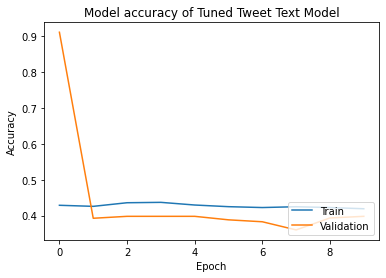

In [222]:
plot_tweettext_tuned_labse=accuracy_plot('Model accuracy of Tuned Tweet Text Model', history_tweettext_tuned_labse)

In [223]:
# Evaluate the model on the test data
print("Evaluate on Tuned Tweet Text test data")
Tweettext_model_tuned_results_labse = TweetText_model_tuned_labse.evaluate(test_data_tweettext_labse,test_labels_tweettext_labse, batch_size=10)

Evaluate on Tuned Tweet Text test data
2914/2914 [==============================] - 3s 986us/step - loss: 0.6716 - accuracy: 0.4372


In [224]:
TweetText_model_tuned_labse.save('TweetText_model_tuned_labse.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='TweetText_model_tuned_labse.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/TweetText_model_tuned_labse.h5')

In [225]:
s3.download_file(import_bucket,
                     'modeling/model_output/TweetText_model_tuned_labse.h5',
                     'TweetText_model_tuned_labse.h5')
# returns a compiled model
# identical to the previous one
TweetText_model_tuned_labse = load_model('TweetText_model_tuned_labse.h5')

In [226]:
#test predict_test
metrics_report_tweettext_tuned_labse=predict_test(TweetText_model_tuned_labse,test_data_tweettext_labse,test_labels_tweettext_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_tweettext_tuned_labse)

              precision    recall  f1-score   support

           0       0.91      0.42      0.57     26238
           1       0.10      0.62      0.18      2901

    accuracy                           0.44     29139
   macro avg       0.51      0.52      0.38     29139
weighted avg       0.83      0.44      0.53     29139



In [227]:
train_account_preds_tweettext_tuned_labse = predict_account(TweetText_model_tuned_labse, train_data_tweettext_labse, bert_embeddings_df_train_labse, df_train_f)

In [228]:
train_account_preds_tweettext_tuned_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_tweettext_tuned_labse.csv', index=False, encoding = "utf_8_sig")

In [229]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_tweettext_tuned_labse = classification_report(np.array(train_account_preds_tweettext_tuned_labse['suspended_label']), np.array(train_account_preds_tweettext_tuned_labse['pred_class']))
print(report_tr_tweettext_tuned_labse)

              precision    recall  f1-score   support

           0       0.94      0.65      0.77      1440
           1       0.09      0.46      0.15       110

    accuracy                           0.64      1550
   macro avg       0.52      0.56      0.46      1550
weighted avg       0.88      0.64      0.73      1550



In [230]:
valid_account_preds_tweettext_tuned_labse = predict_account(TweetText_model_tuned_labse, valid_data_tweettext_labse, bert_embeddings_df_valid_labse, df_valid_f)

In [231]:
valid_account_preds_tweettext_tuned_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_tweettext_tuned_labse.csv', index=False, encoding = "utf_8_sig")

In [232]:
#report = classification_report(np.array(test_labels), predictions)
report_v_tweettext_tuned_labse_labse = classification_report(np.array(valid_account_preds_tweettext_tuned_labse['suspended_label']), np.array(valid_account_preds_tweettext_tuned_labse['pred_class']))
print(report_v_tweettext_tuned_labse_labse)

              precision    recall  f1-score   support

           0       0.92      0.65      0.76       523
           1       0.06      0.29      0.10        41

    accuracy                           0.62       564
   macro avg       0.49      0.47      0.43       564
weighted avg       0.86      0.62      0.71       564



In [233]:
test_account_preds_tweettext_tuned_labse = predict_account(TweetText_model_tuned_labse, test_data_tweettext_labse, bert_embeddings_df_test_labse, df_test_f)

In [234]:
test_account_preds_tweettext_tuned_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_tweettext_tuned_labse.csv', index=False, encoding = "utf_8_sig")

In [235]:
#report = classification_report(np.array(test_labels), predictions)
report_te_tweettext_tuned_labse = classification_report(np.array(test_account_preds_tweettext_tuned_labse['suspended_label']), np.array(test_account_preds_tweettext_tuned_labse['pred_class']))
print(report_te_tweettext_tuned_labse)

              precision    recall  f1-score   support

           0       0.92      0.63      0.75       467
           1       0.10      0.45      0.17        44

    accuracy                           0.62       511
   macro avg       0.51      0.54      0.46       511
weighted avg       0.85      0.62      0.70       511



In [236]:
#train vs validation accuracy plot
print(plot_tweettext_tuned_labse)
#test accuracy
print("test loss, test accuracy:", Tweettext_model_tuned_results_labse)
#Countries labels predicted
#print(predicted_countries_tweettext_tuned)
#Classification report
print(metrics_report_tweettext_tuned_labse)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [0.6715512275695801, 0.437214732170105]
              precision    recall  f1-score   support

           0       0.91      0.42      0.57     26238
           1       0.10      0.62      0.18      2901

    accuracy                           0.44     29139
   macro avg       0.51      0.52      0.38     29139
weighted avg       0.83      0.44      0.53     29139



#### Account Only Model 

In [174]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(30,)

In [175]:
def tuner_builder1(hp):
    inputs = keras.Input(shape=input_shape_acc, name="Tuned_Account_Info_Inputs")
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Account_Info_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model

In [176]:
#tuner settings 
Acc_info_tuner = kt.Hyperband(
    tuner_builder1,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_acc_info2',
    project_name = 'Parameters_trials_acc_info2')

In [179]:
#run through tuner
Acc_info_tuner.search(train_data_acc, train_labels,validation_data=(valid_data_acc, valid_labels),callbacks=[callback1,ClearTrainingOutput()])


Trial 90 Complete [00h 00m 28s]
val_accuracy: 0.9130434989929199

Best val_accuracy So Far: 0.9130434989929199
Total elapsed time: 00h 38m 40s
INFO:tensorflow:Oracle triggered exit


In [180]:
#gets best parameters
best_hyper_Acc_info = Acc_info_tuner.get_best_hyperparameters(1)[0]
best_hyper_Acc_info
    

In [181]:
print('Best Parameters for 1st Dense layer is', best_hyper_Acc_info.get('units'))

Best Parameters for 1st Dense layer is 150


In [182]:
print('Best Parameters for 2nd Dense layer is', best_hyper_Acc_info.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [183]:
print('Best Parameters for 3rd Dense layer is', best_hyper_Acc_info.get('units2'))

Best Parameters for 3rd Dense layer is 40


In [184]:
print('Best Parameters for Dropout layer is', best_hyper_Acc_info.get('dropout'))

Best Parameters for Dropout layer is 0.1


In [185]:
print('Best learning rate for the ADAM is', best_hyper_Acc_info.get('learning_rate'))

Best learning rate for the ADAM is 0.0016275322152575935


In [186]:
#applies to tuning to model
Acc_info_model_tuned= Acc_info_tuner.hypermodel.build(best_hyper_Acc_info)

In [188]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned Account Information model")
history_acc_info_tuned = Acc_info_model_tuned.fit(train_data_acc, train_labels, epochs=10, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight = class_weights)

Fit model on training data with tuned Account Information model
Epoch 1/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.3137 - accuracy: 0.5284 - val_loss: nan - val_accuracy: 0.1229
Epoch 2/10
7159/7159 [==============================] - 14s 2ms/step - loss: 1.2931 - accuracy: 0.5281 - val_loss: nan - val_accuracy: 0.3997
Epoch 3/10
7159/7159 [==============================] - 18s 3ms/step - loss: 1.3043 - accuracy: 0.5427 - val_loss: nan - val_accuracy: 0.1229
Epoch 4/10
7159/7159 [==============================] - 21s 3ms/step - loss: 1.2874 - accuracy: 0.5421 - val_loss: nan - val_accuracy: 0.5421
Epoch 5/10
7159/7159 [==============================] - 18s 3ms/step - loss: 1.3033 - accuracy: 0.4827 - val_loss: nan - val_accuracy: 0.4365
Epoch 6/10
7159/7159 [==============================] - 19s 3ms/step - loss: 1.2852 - accuracy: 0.5624 - val_loss: nan - val_accuracy: 0.6530
Epoch 7/10
7159/7159 [==============================] - 17s 2ms/step - loss: 1.2813 

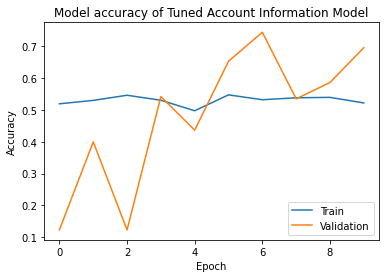

In [189]:
plot_acc_info_tuned=accuracy_plot('Model accuracy of Tuned Account Information Model', history_acc_info_tuned)

In [191]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned Account Information model on test data")
acc_info_tuned_results = Acc_info_model_tuned.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate tuned Account Information model on test data
2914/2914 [==============================] - 3s 991us/step - loss: nan - accuracy: 0.6559


#### Save Model 

In [192]:
Acc_info_model_tuned.save('Acc_info_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='Acc_info_model_tuned.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Acc_info_model_tuned.h5')



#### Load Model 

In [193]:
s3.download_file(import_bucket,
                     'modeling/model_output/Acc_info_model_tuned.h5',
                     'Acc_info_model_tuned.h5')
# returns a compiled model
# identical to the previous one
Tweettext_model = load_model('Acc_info_model_tuned.h5')

#### Predict 

Tweets

In [195]:
#test predict_test
metrics_report_acc_tuned=predict_test(Acc_info_model_tuned,test_data_acc,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_acc_tuned)

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     26238
           1       0.14      0.48      0.22      2901

    accuracy                           0.66     29139
   macro avg       0.53      0.58      0.50     29139
weighted avg       0.84      0.66      0.72     29139



Accounts

In [197]:
train_account_preds_acc_tuned = predict_account(Acc_info_model_tuned, train_data_acc, bert_embeddings_df_train, df_train_f)

In [198]:
train_account_preds_acc_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

In [199]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_acc_tuned = classification_report(np.array(train_account_preds_acc_tuned['suspended_label']), np.array(train_account_preds_acc_tuned['pred_class']))
print(report_tr_acc_tuned)


              precision    recall  f1-score   support

           0       0.93      0.46      0.62      1440
           1       0.07      0.56      0.13       110

    accuracy                           0.47      1550
   macro avg       0.50      0.51      0.37      1550
weighted avg       0.87      0.47      0.58      1550



In [200]:
valid_account_preds_acc_tuned = predict_account(Acc_info_model_tuned, valid_data_acc, bert_embeddings_df_valid, df_valid_f)
valid_account_preds_acc_tuned

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
0,0PbG8K7S2ioNjL4,0,1.027080,0.256770,0
1,1s11370977,0,7.050694,0.783410,1
2,2nk96A8nKuoTNMO,0,0.000000,NaN,0
3,2wuajzMCkrXhVJR,0,2.155278,0.718426,1
4,3P7EJm4JEW4rzyr,0,16.812952,0.700540,1
...,...,...,...,...,...
559,zhangta50319667,0,8.892814,0.635201,1
560,zhutnut,0,0.000000,NaN,0
561,zoub98237444,0,6.069143,0.758643,1
562,zuoye0510,0,2.501173,0.039701,0


In [201]:
valid_account_preds_acc_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

In [202]:
#report = classification_report(np.array(test_labels), predictions)
report_v_acc_tuned = classification_report(np.array(valid_account_preds_acc_tuned['suspended_label']), np.array(valid_account_preds_acc_tuned['pred_class']))
print(report_v_acc_tuned)

              precision    recall  f1-score   support

           0       0.93      0.67      0.78       523
           1       0.08      0.39      0.14        41

    accuracy                           0.65       564
   macro avg       0.51      0.53      0.46       564
weighted avg       0.87      0.65      0.73       564



In [203]:
test_account_preds_acc_tuned = predict_account(Acc_info_model_tuned, test_data_acc, bert_embeddings_df_test, df_test_f)
test_account_preds_acc_tuned

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
0,0zGrNrwl6bRjIv9,0,6.001352,0.545577,1
1,1hs6oMXjD9toV8o,0,0.000000,NaN,0
2,2IKcY5haEk7adWs,0,62.913994,0.827816,1
3,2R0fErCwAWXV2mG,0,0.000000,NaN,0
4,2ebRkaTgSVMcGrl,0,0.000000,NaN,0
...,...,...,...,...,...
506,zh94004641,0,0.000000,NaN,0
507,zhong_yuming,0,0.485596,0.485596,0
508,zhongshusheren,0,0.000000,NaN,0
509,zhuguli10808518,0,0.338965,0.021185,0


In [204]:
test_account_preds_acc_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")


In [206]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc_tuned_tuned = classification_report(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))
print(report_te_acc_tuned_tuned)

              precision    recall  f1-score   support

           0       0.92      0.69      0.79       467
           1       0.11      0.39      0.17        44

    accuracy                           0.67       511
   macro avg       0.51      0.54      0.48       511
weighted avg       0.85      0.67      0.74       511



Account Information Model with Fine Tuning Results

In [208]:
#train vs validation accuracy plot
print(plot_acc_info_tuned)
#test accuracy
print("test loss, test accuracy:", acc_info_tuned_results)
#Countries labels predicted
#print(predicted_countries_acc_info_tuned)
#Classification report
print(metrics_report_acc_tuned)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [nan, 0.655890703201294]
              precision    recall  f1-score   support

           0       0.92      0.68      0.78     26238
           1       0.14      0.48      0.22      2901

    accuracy                           0.66     29139
   macro avg       0.53      0.58      0.50     29139
weighted avg       0.84      0.66      0.72     29139



#### Combined Model

Multilingual BERT

In [169]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(798,)

In [170]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [172]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined2',
    project_name = 'Parameters_trials_combined_4')

In [173]:
#run through tuner
Combined_tuner.search(train_data, train_labels,validation_data=(valid_data, valid_labels),
             callbacks=[callback1,ClearTrainingOutput()])

Trial 90 Complete [00h 00m 36s]
val_accuracy: 0.9130434989929199

Best val_accuracy So Far: 0.9130434989929199
Total elapsed time: 00h 41m 15s
INFO:tensorflow:Oracle triggered exit


In [174]:
#gets best parameters
best_hyper_combined = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined

In [175]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined.get('units'))

Best Parameters for 1st Dense layer is 90


In [176]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [177]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined.get('units2'))

Best Parameters for 3rd Dense layer is 20


In [178]:
print('Best Parameters for Dropout layer is', best_hyper_combined.get('dropout'))

Best Parameters for Dropout layer is 0.30000000000000004


In [179]:
print('Best learning rate for the ADAM is', best_hyper_combined.get('learning_rate'))

Best learning rate for the ADAM is 0.0001336992122024675


In [180]:
#applies to tuning to model
Combined_model_tuned= Combined_tuner.hypermodel.build(best_hyper_combined)

In [237]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned = Combined_model_tuned.fit(train_data, train_labels, epochs=10, batch_size=15,
                   validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data with tuned model
Epoch 1/10
7159/7159 [==============================] - 15s 2ms/step - loss: 1.3144 - accuracy: 0.4982 - val_loss: nan - val_accuracy: 0.1981
Epoch 2/10
7159/7159 [==============================] - 16s 2ms/step - loss: 1.2970 - accuracy: 0.5303 - val_loss: nan - val_accuracy: 0.8600
Epoch 3/10
7159/7159 [==============================] - 16s 2ms/step - loss: 1.3069 - accuracy: 0.5218 - val_loss: nan - val_accuracy: 0.1306
Epoch 4/10
7159/7159 [==============================] - 16s 2ms/step - loss: 1.2883 - accuracy: 0.5401 - val_loss: nan - val_accuracy: 0.1532
Epoch 5/10
7159/7159 [==============================] - 16s 2ms/step - loss: 1.3057 - accuracy: 0.5130 - val_loss: nan - val_accuracy: 0.4063
Epoch 6/10
7159/7159 [==============================] - 16s 2ms/step - loss: 1.2851 - accuracy: 0.5293 - val_loss: nan - val_accuracy: 0.1229
Epoch 7/10
7159/7159 [==============================] - 17s 2ms/step - loss: 1.2808 - accuracy: 0.5391 -

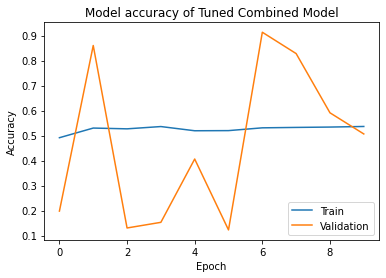

In [238]:
plot_combined_tuned=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned)

In [239]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results = Combined_model_tuned.evaluate(test_data, test_labels, batch_size=10)

Evaluate tuned model on test data
2914/2914 [==============================] - 3s 996us/step - loss: nan - accuracy: 0.3743


#### Save Model 

In [244]:
Combined_model_tuned.save('Combined_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='Combined_model_tuned.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Combined_model_tuned.h5')

#### Import Model 

In [245]:
s3.download_file(import_bucket,
                     'modeling/model_output/Combined_model_tuned.h5',
                     'Combined_model_tuned.h5')
# returns a compiled model
# identical to the previous one
Combined_model_tuned = load_model('Combined_model_tuned.h5')

#### Predict

Tweets

In [246]:
#test predict_test
metrics_report_comb_tuned=predict_test(Combined_model_tuned,test_data,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_comb_tuned)

              precision    recall  f1-score   support

           0       0.88      0.35      0.50     26238
           1       0.09      0.56      0.15      2901

    accuracy                           0.37     29139
   macro avg       0.48      0.46      0.33     29139
weighted avg       0.80      0.37      0.47     29139



Accounts

In [247]:
train_account_preds_comb_tuned = predict_account(Combined_model_tuned, train_data, bert_embeddings_df_train, df_train_f)

In [248]:
train_account_preds_comb_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

In [249]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_comb_tuned = classification_report(np.array(train_account_preds_comb_tuned['suspended_label']), np.array(train_account_preds_comb_tuned['pred_class']))
print(report_tr_comb_tuned)

              precision    recall  f1-score   support

           0       0.95      0.20      0.33      1440
           1       0.08      0.86      0.14       110

    accuracy                           0.25      1550
   macro avg       0.51      0.53      0.24      1550
weighted avg       0.89      0.25      0.32      1550



In [250]:
valid_account_preds_comb_tuned = predict_account(Combined_model_tuned, valid_data, bert_embeddings_df_valid, df_valid_f)

In [251]:
valid_account_preds_comb_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

In [252]:
#report = classification_report(np.array(test_labels), predictions)
report_v_comb_tuned = classification_report(np.array(valid_account_preds_comb_tuned['suspended_label']), np.array(valid_account_preds_comb_tuned['pred_class']))
print(report_v_comb_tuned)

              precision    recall  f1-score   support

           0       0.95      0.47      0.63       523
           1       0.09      0.71      0.17        41

    accuracy                           0.49       564
   macro avg       0.52      0.59      0.40       564
weighted avg       0.89      0.49      0.59       564



In [253]:
test_account_preds_comb_tuned = predict_account(Combined_model_tuned, test_data, bert_embeddings_df_test, df_test_f)

In [254]:
test_account_preds_comb_tuned.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

In [256]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))
print(report_te_comb)

              precision    recall  f1-score   support

           0       0.91      0.47      0.62       467
           1       0.08      0.50      0.14        44

    accuracy                           0.47       511
   macro avg       0.49      0.48      0.38       511
weighted avg       0.84      0.47      0.58       511



Combined Model with Fine Tuning Results

In [257]:
#train vs validation accuracy plot
print(plot_combined_tuned)
#test accuracy
print("test loss, test accuracy:", Combined_model_tuned_results)
#Countries labels predicted
#print(predicted_countries_tuned)
#Classification report
print(metrics_report_comb_tuned)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [nan, 0.3742750287055969]
              precision    recall  f1-score   support

           0       0.88      0.35      0.50     26238
           1       0.09      0.56      0.15      2901

    accuracy                           0.37     29139
   macro avg       0.48      0.46      0.33     29139
weighted avg       0.80      0.37      0.47     29139



Combined Model with LAbse

In [258]:
#gets shape of the data for the model
input_shape_combined_labse=train_data_labse[0].shape
input_shape_combined_labse

(798,)

In [259]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined_labse, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [260]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined2',
    project_name = 'Parameters_trials_combined_labse_1')

In [261]:
#run through tuner
Combined_tuner.search(train_data_labse, train_labels_labse,validation_data=(valid_data_labse, valid_labels_labse),
             callbacks=[callback1,ClearTrainingOutput()])

Trial 90 Complete [00h 00m 32s]
val_accuracy: 0.9117730855941772

Best val_accuracy So Far: 0.9117730855941772
Total elapsed time: 00h 42m 08s
INFO:tensorflow:Oracle triggered exit


In [262]:
#gets best parameters
best_hyper_combined_labse = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined_labse

In [263]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined_labse.get('units'))

Best Parameters for 1st Dense layer is 170


In [264]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined_labse.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [265]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined_labse.get('units2'))

Best Parameters for 3rd Dense layer is 40


In [266]:
print('Best Parameters for Dropout layer is', best_hyper_combined_labse.get('dropout'))

Best Parameters for Dropout layer is 0.4


In [267]:
print('Best learning rate for the ADAM is', best_hyper_combined_labse.get('learning_rate'))

Best learning rate for the ADAM is 0.0017507470678438822


In [268]:
#applies to tuning to model
Combined_model_tuned_labse= Combined_tuner.hypermodel.build(best_hyper_combined_labse)

In [269]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned_labse = Combined_model_tuned.fit(train_data_labse, train_labels_labse, epochs=10, batch_size=15,
                   validation_data=(valid_data_labse, valid_labels_labse), class_weight = class_weights_labse)

Fit model on training data with tuned model
Epoch 1/10
7159/7159 [==============================] - 17s 2ms/step - loss: nan - accuracy: 0.8948 - val_loss: nan - val_accuracy: 0.9118
Epoch 2/10
7159/7159 [==============================] - 15s 2ms/step - loss: nan - accuracy: 0.8948 - val_loss: nan - val_accuracy: 0.9118
Epoch 3/10
7159/7159 [==============================] - 16s 2ms/step - loss: nan - accuracy: 0.8948 - val_loss: nan - val_accuracy: 0.9118
Epoch 4/10
7159/7159 [==============================] - 16s 2ms/step - loss: nan - accuracy: 0.8948 - val_loss: nan - val_accuracy: 0.9118
Epoch 5/10
7159/7159 [==============================] - 16s 2ms/step - loss: nan - accuracy: 0.8948 - val_loss: nan - val_accuracy: 0.9118
Epoch 6/10
7159/7159 [==============================] - 16s 2ms/step - loss: nan - accuracy: 0.8948 - val_loss: nan - val_accuracy: 0.9118
Epoch 7/10
7159/7159 [==============================] - 17s 2ms/step - loss: nan - accuracy: 0.8948 - val_loss: nan - val_

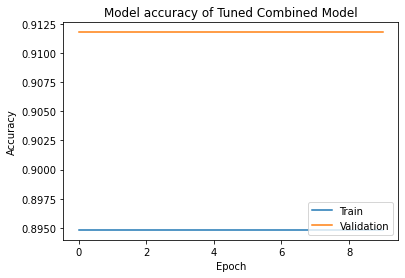

In [270]:
plot_combined_tuned_labse=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned_labse)

In [271]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results_labse = Combined_model_tuned_labse.evaluate(test_data_labse, test_labels_labse, batch_size=10)

Evaluate tuned model on test data
2914/2914 [==============================] - 4s 1ms/step - loss: nan - accuracy: 0.1831


In [272]:
Combined_model_tuned_labse.save('Combined_model_tuned_labse.h5')  # creates a HDF5 file 'my_model.h5'
s3.upload_file(Filename='Combined_model_tuned_labse.h5',
                  Bucket=import_bucket,
                  Key='modeling/model_output/Combined_model_tuned_labse.h5')

In [273]:
s3.download_file(import_bucket,
                     'modeling/model_output/Combined_model_tuned_labse.h5',
                     'Combined_model_tuned_labse.h5')
# returns a compiled model
# identical to the previous one
Combined_model_tuned_labse = load_model('Combined_model_tuned_labse.h5')

In [274]:
#test predict_test
metrics_report_comb_tuned_labse=predict_test(Combined_model_tuned_labse,test_data_labse,test_labels_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_comb_tuned_labse)

              precision    recall  f1-score   support

           0       0.74      0.06      0.11     26238
           1       0.09      0.80      0.16      2901

    accuracy                           0.13     29139
   macro avg       0.41      0.43      0.13     29139
weighted avg       0.67      0.13      0.12     29139



Train

In [275]:
train_account_preds_comb_tuned_labse = predict_account(Combined_model_tuned_labse, train_data_labse, bert_embeddings_df_train_labse, df_train_f)

In [276]:
train_account_preds_comb_tuned_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/train_account_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

In [277]:
#report = classification_report(np.array(test_labels), predictions)
report_tr_comb_tuned_labse = classification_report(np.array(train_account_preds_comb_tuned_labse['suspended_label']), np.array(train_account_preds_comb_tuned_labse['pred_class']))
print(report_tr_comb_tuned_labse)

              precision    recall  f1-score   support

           0       0.95      0.27      0.42      1440
           1       0.08      0.81      0.14       110

    accuracy                           0.31      1550
   macro avg       0.51      0.54      0.28      1550
weighted avg       0.89      0.31      0.40      1550



Valid

In [278]:
valid_account_preds_comb_tuned_labse = predict_account(Combined_model_tuned_labse, valid_data_labse, bert_embeddings_df_valid_labse, df_valid_f)

In [279]:
valid_account_preds_comb_tuned_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/valid_account_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

In [280]:
#report = classification_report(np.array(test_labels), predictions)
report_v_comb_tuned_labse = classification_report(np.array(valid_account_preds_comb_tuned_labse['suspended_label']), np.array(valid_account_preds_comb_tuned_labse['pred_class']))
print(report_v_comb_tuned_labse)

              precision    recall  f1-score   support

           0       0.95      0.31      0.46       523
           1       0.08      0.80      0.15        41

    accuracy                           0.34       564
   macro avg       0.52      0.56      0.31       564
weighted avg       0.89      0.34      0.44       564



Test

In [281]:
test_account_preds_comb_tuned_labse = predict_account(Combined_model_tuned_labse, test_data_labse, bert_embeddings_df_test_labse, df_test_f)

In [282]:
test_account_preds_comb_tuned_labse.to_csv('s3://joe-exotic-2020/modeling/account_level_results/test_account_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

In [283]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb_labse = classification_report(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))
print(report_te_comb_labse)

              precision    recall  f1-score   support

           0       0.92      0.31      0.46       467
           1       0.09      0.73      0.16        44

    accuracy                           0.34       511
   macro avg       0.51      0.52      0.31       511
weighted avg       0.85      0.34      0.44       511



In [284]:
#train vs validation accuracy plot
print(plot_combined_tuned_labse)
#test accuracy
print("test loss, test accuracy:", Combined_model_tuned_results_labse)
#Countries labels predicted
#print(predicted_countries_tuned)
#Classification report
print(metrics_report_comb_tuned_labse)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [nan, 0.13487079739570618]
              precision    recall  f1-score   support

           0       0.74      0.06      0.11     26238
           1       0.09      0.80      0.16      2901

    accuracy                           0.13     29139
   macro avg       0.41      0.43      0.13     29139
weighted avg       0.67      0.13      0.12     29139

